<div style="text-align: right">
    Bill Quinn<br>
    October 19, 2020
</div>

# Named Entity Recognition: People and Names Authority

This notebook uses the encoding practices of the JQA diaries to assess the accuracy of NER. The NER results are limited on rules interpreted from the encoding practices.

#### Findings

When NER finds an entity, it is typically accurate. There do not seem to be many (if any) false positives, making NER potentially useful for building networks where strong precision is necessary for making historical claims.

But, NER misses most of the entities encoded by the editions teams; there are many false negatives. This suggests that NER might be a poor tool for discovery entities. I think NER struggles with the informal language of JQA's diaries, which doesn't follow the rule-based probabilities NER expects.

#### Steps

0. Import Data & Extract NER
1. Measure Encoded Entities (unique identifiers) against Recognized Entities
2. Fuzzy Match: Compare Encoded (text content) vs. Recognized Named Entities
    - a. Extract text content from parsed XML
    - b. Fuzzy Match Encoded (text content) & Recognized Entities
    - c. Sort Fuzzy Matches into Categories
3. Explore Unmatched Entities
    - a. Gather Unmatched Entities
    - b. Examine an Unmatched Entity
    - c. Re-run NER on Encoded Entities <i>NOT</i> Found in First Pass
    - d. View Newly Matched Entities with re-run NER Results
    - e. Examine Known/Unknown Status of Entities
4. Findings


#### Sketch of DataFrame Derivatives

This map lists the main dataframes used throughout this notebook and explains where and how they were derived.

1. "df"
    - This is one of the main dataframes used at the beginning of the notebook. It contains refKeys and the full text of each entry.
2. "encoded_ents"
    - This dataframe contains similar info as 'df' and significantly adds the text content of "persRef" tags.
3. "entities"
    - This dataframe is merged from 'df' and 'encoded_ents.' It adds a column for the NER results.
        - a. matches: this subset of 'entities' contains potential and likely (fuzzy) matches.
        - b. unmatched: this subset of 'entities' have <i>no</i> matches at all.
        - c. unknown_ents: a subset of 'entities' with "known/unknown" status based on refKey.

#### Sources:

Arias, Francisco Javier Carrera, "[Fuzzy String Matching in Python](https://www.datacamp.com/community/tutorials/fuzzy-string-python)," <i>DataCamp</i>, Accessed 10/05/2020.

alexis, "[Extract list of Persons and Organizations using Stanford NER Tagger in NLTK](https://stackoverflow.com/questions/30664677/extract-list-of-persons-and-organizations-using-stanford-ner-tagger-in-nltk)," <i>Stack Overflow</i>, Accessed 10/01/2020.

Li, Susan, "[Named Entity Recognition with NLTK and Spacy](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da)," <i>towards data science</i>, Accessed 10/01/2020.

https://stackoverflow.com/questions/30664677/extract-list-of-persons-and-organizations-using-stanford-ner-tagger-in-nltk

# 0. Import Data & Extract NER

The first step is to import the parsed XML data, which includes the unique identifiers of each referenced person. The unique identifier will tentatively serve as the baseline (or groundtruth) of named entities. The performance of NER will later be measured against these XML results.

In [1]:
# Import necessary libraries.
import re, nltk, warnings, glob, csv, sys, os
import pandas as pd
import numpy as np
import seaborn as sns
import xml.etree.ElementTree as ET
from itertools import chain
from nltk import word_tokenize, pos_tag, ne_chunk, Tree
from fuzzywuzzy import fuzz, process

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore") # specify ignore: , DeprecationWarning

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/SemanticData/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Output/ParsedXML/JQA_dataframe.txt',
                 sep = '\t') \
    .dropna()

df.head()

,file,entry,date,people,text
9,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,1825-01-10,"herkimer-john,adams-parmenio,ketchum-unknown,m...",10. VI:45. Visits at my house from John Herkim...
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,"plumer-william2,hellen-thomas,johnson-george,l...","11. VII. Visitors, W. Plumer jr. Settled with ..."
11,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-12,1825-01-12,"hellen-thomas,vanburen-martin,woodward-augustu...",12. V:30.Thomas J. Hellen went at 6. in the St...
12,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-13,1825-01-13,"barbour-james,rush-richard,king-rufus,johnston...",13. VI:15. I called this morning on James Barb...
13,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-14,1825-01-14,"baylies-francis,coggeshall-unknown,lear-tobias...",14 V. A rainy day: consequently not much inter...


#### Extract Named Entities

This function, copied from a [StackOverflow answer from alexis](https://stackoverflow.com/questions/30664677/extract-list-of-persons-and-organizations-using-stanford-ner-tagger-in-nltk), joins text strings that belong to the same entity tree, such as first and last names.

In [2]:
%%time

# Declare Function to Return Named Entity Chunk as String
def get_continuous_chunks(text, label_list): # changed 'list' to 'label_list'
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() in label_list: # changed '== label' to 'in label_list'
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append((named_entity, subtree.label())) # changed: , subtree.label()
                current_chunk = []
        else:
            continue

    return continuous_chunk

# Apply function to text column and create a new 'ner_people' column in the dataframe.
df['ner_people'] = df.apply(lambda row: get_continuous_chunks(row['text'], ['PERSON']),
                            axis = 1) 


# Split tuples in 'ner_people' into two lists, one for named entities and another for labels.
def split_tuple_rtn_lists(aList):
    listOne = []
    listTwo = []
    for tup in aList:
        listOne.append(tup[0])
        listTwo.append(tup[1])
    return listOne, listTwo

df['ner_people'], df['ner_labels'] = zip(*df['ner_people'] \
                                            .apply(split_tuple_rtn_lists))


df.head()

CPU times: user 2min 41s, sys: 692 ms, total: 2min 42s
Wall time: 2min 44s


,file,entry,date,people,text,ner_people,ner_labels
9,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,1825-01-10,"herkimer-john,adams-parmenio,ketchum-unknown,m...",10. VI:45. Visits at my house from John Herkim...,"[John Herkimer, Herkimer, Meyer, Adams, Dan, E...","[PERSON, PERSON, PERSON, PERSON, PERSON, PERSO..."
10,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-11,1825-01-11,"plumer-william2,hellen-thomas,johnson-george,l...","11. VII. Visitors, W. Plumer jr. Settled with ...","[Hay, Ingersoll, Ingersoll, Baron Tuyll, Coast...","[PERSON, PERSON, PERSON, PERSON, PERSON, PERSO..."
11,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-12,1825-01-12,"hellen-thomas,vanburen-martin,woodward-augustu...",12. V:30.Thomas J. Hellen went at 6. in the St...,"[Hellen, Van Buren, Woodward, Calhoun, Bradley...","[PERSON, PERSON, PERSON, PERSON, PERSON, PERSO..."
12,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-13,1825-01-13,"barbour-james,rush-richard,king-rufus,johnston...",13. VI:15. I called this morning on James Barb...,"[James Barbour, Johnston, Mechanics Bank, John...","[PERSON, PERSON, PERSON, PERSON, PERSON, PERSO..."
13,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-14,1825-01-14,"baylies-francis,coggeshall-unknown,lear-tobias...",14 V. A rainy day: consequently not much inter...,"[Dunlop, Van Ness, Van Ness, Van Ness, William...","[PERSON, PERSON, PERSON, PERSON, PERSON, PERSO..."


# 1. Summarize Encoded (unique identifiers) & Recognized Entities

This cell provides an overview of how many people (entities) are encoded and how many are recognized. How many are in each group and which entities only appear in one group? The goal is to discern if there are important patterns that might be useful for modifying or re-training the NER model.

#### Compare Total Number of Encoded and Recognized Entities.

people        25442
ner_people    22764
dtype: int64 

CPU times: user 83 ms, sys: 6.84 ms, total: 89.8 ms
Wall time: 91 ms


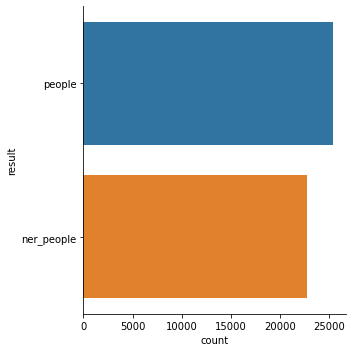

In [3]:
%%time

# Subset dataframe to focus on two columns: people & ner_people.
counts = df[['people', 'ner_people']]

# Split list into individual items and count number of items.
counts['people'] = counts['people'].str.split(r',|;').str.len()
counts['ner_people'] = counts['ner_people'].str.len()

# Print totals.
print (counts[['people', 'ner_people']].sum(), '\n')

counts = counts[['people', 'ner_people']].sum() \
    .reset_index().rename(columns = {'index':'result', 0:'count'})

# Plot results.
g = sns.catplot(
    data = counts, kind = 'bar',
    y = 'result', x = 'count'
)

#### Visualize Expected/Unexpected Behaviors

The encoding practices of the JQA diaries capture the first mention of a person within each entry. Repeated mentions within the same entry are not encoded. The encoding practices also encode entities understood by context but not necessarily plain text. For example, when JQA refers to someone's sons or daughters, the encoders supply reference keys that identify these historical people.

Based on these practices, the following graph visualizes the "expectations" of how many encoded entities there are relative to recognized entities.

       result     count
0  unexpected  0.618371
1    expected  0.291963
2       match  0.089666 

CPU times: user 181 ms, sys: 7.06 ms, total: 188 ms
Wall time: 197 ms


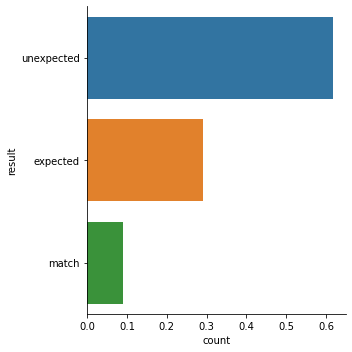

In [4]:
%%time

# Subset dataframe to focus on two columns: people & ner_people.
counts = df[['people', 'ner_people']]

# Split list into individual items and count number of items.
counts['people'] = counts['people'].str.split(r',|;').str.len()
counts['ner_people'] = counts['ner_people'].str.len()


# Define function to distinguish between expected behaviors by creating a new column.
# The JQA encodes the first mention of a person in each entry.
# I expect that NER will capture that mention & the following mentions.
# Therefore, there will be more NER entities than encoded.
def match_results(row):
    if row['people'] < row['ner_people']:
        val = 'expected'
    elif row['people'] == row['ner_people']:
        val = 'match'
    else:
        val = 'unexpected'
    return val

counts['results'] = counts.apply(match_results, axis = 1)

# Return a ratio of results.
counts = counts['results'].value_counts(normalize= True) \
    .reset_index() \
    .rename(columns = {'index':'result', 'results':'count'})

print (counts, '\n')

# Plot results.
g = sns.catplot(
    data = counts, kind = 'bar',
    y = 'result', x = 'count'
)

The above results indicate that the NER method missed at least one name in many documents. This could demonstrate that the tool is poorly equipped to extract data about people from JQA diaries. It could also be the case, though, that the encoding practices are more generous than the NER. For example, a phrase like, "Her two daughters," signifies three entities. An encoder might capture this but NER would not. NER is stricter with what it considers an entity because it follows rules and probabilities centered on grammar.

## 2. Fuzzy Matching: Compare Encoded (text content) vs. Recognized Named Entities

The goal of this section is to return a list of Encoded entities (discovered by humans) that are not shared with Recognized (discovered by probabilities). The remaining list should shed light on the different behaviors.

1. Sequester encoded entities that do not match recognized entities. Although encoded entities are more accurately "recognized," there are more of them and they can effectively differentiate the two sets.

    a. Extract parsed XML: unique ID & tag content.<br>
    b. Compare NER to tag content.<br>
    c. Examine left over encoded entities.<br>
    
### a. Extract text content from parsed XML

In [5]:
%%time

# Based on previous notebook: JQA_XML-Parser.

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/SemanticData/"

# Gather all .xml files using glob.
list_of_files = glob.glob(abs_dir + "Data/JQA/*/*.xml")

# Declare regex to simplify file paths below
regex = re.compile(r'.*/\d{4}/(.*)')


# Create dataframe to store results.
encoded_ents = pd.DataFrame(columns = ['file', 'entry', 'refKey', 'people'])

#     Loop through each file within a directory.
for file in list_of_files:
    tree = ET.parse(file)
    root = tree.getroot()
    namespace = re.match(r"{(.*)}", str(root.tag))
    ns = {"ns":namespace.group(1)}
    reFile = str(regex.search(file).groups())

    for eachDoc in root.findall('.//ns:div/[@type="entry"]', ns):
        entry = eachDoc.get('{http://www.w3.org/XML/1998/namespace}id')
        for elem in eachDoc.findall('.//ns:p/ns:persRef', ns):
            refKey = elem.get('ref')
            
            name = elem.text
            try:
                clean_name = re.sub(r'\s+', ' ', name)
            except TypeError:
                clean_name = name
                
            encoded_ents = encoded_ents.append({'file':reFile,
                                                'entry':entry,
                                                'refKey':refKey,
                                                'people':clean_name},
                                               ignore_index = True)
                
encoded_ents.head()

CPU times: user 54.9 s, sys: 237 ms, total: 55.1 s
Wall time: 55.8 s


,file,entry,refKey,people
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer
1,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,adams-parmenio,Parmenio Adams
2,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,ketchum-unknown,M
3,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,meyer-unknown3,Meyer
4,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,adams-daniel,Dan


### b. Fuzzy Match Encoded & Recognized Entities

The following cell searches for fuzzy, or near, matches between the named entity recognition process and the element content of encoded entities. The goal is to discover text content, surrounded by element tags, that are similar to the text content discovered by named entity recognition.

The search only extends to possible matches within an entry. This limitation assumes that the relationship between recognized and encoded entities is most coherent within an entry.

#### Explanation of Fuzzy Matching

FuzzyWuzzy measures similarity based on the Levenshtein Distance. According the Francisco Javier Carrera Arias, in "[Fuzzy String Matching in Python](https://www.datacamp.com/community/tutorials/fuzzy-string-python):

   > The Levenshtein distance is a metric to measure how apart are two sequences of words. In other words, it measures the minimum number of edits that you need to do to change a one-word sequence into the other. These edits can be insertions, deletions or substitutions. This metric was named after Vladimir Levenshtein, who originally considered it in 1965.
   
StackOverflow Explanations/Solutions:

1. Different FuzzyWuzzy functions: [Rick Hanlon II and Dennis Golomazov](https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings).

2. Function for applying fuzzy matches to dataframe: [maxymoo](https://stackoverflow.com/questions/42847396/fuzzy-wuzzy-string-matching-on-2-large-data-sets-based-on-a-condition-python).

In [6]:
%%time

# Create empty dataframe to populate with fuzzy matches.
entities = pd.DataFrame(columns = ['file', 'entry', 'refKey', 'enc_ents', 'ner_ents'])

# Loop through encoded entities and match with named-entity dataframe.
for index, row in encoded_ents.iterrows():
    
#   Subset original 'df' dataframe by columns & select targeted rows.  
    ner_people = df[['file', 'entry', 'ner_people']] \
        .loc[df['entry'] == row['entry']]['ner_people']
    
#     Append rows to empty 'entities' dataframe.
    entities = entities.append({'file': row['file'],
                                'entry': row['entry'],
                                'refKey': row['refKey'],
                                'enc_ents': row['people'],
                                'ner_ents': ner_people.values.tolist()},
                               ignore_index = True)

# Unnest list of recognized entities.
entities = entities.explode('ner_ents')

# Examples of different fuzzy arguments.
print ('Similarity of "John" & "John Herkimer" Using Different Fuzzy Arguments:',
       '\n\tRatio: ', fuzz.ratio('John', 'John Herkimer'),
       '\n\tPartial Ratio: ', fuzz.partial_ratio('John', 'John Herkimer'),
       '\n\tToken Set Ratio: ', fuzz.token_set_ratio('John', 'John Herkimer'),
       '\n\tToken Sort Ratio: ', fuzz.token_sort_ratio('John', 'John Herkimer'), '\n')

# Define function to fuzzy match string in one column with list values in another.
def extract_matches(row):
    try:
        matches = process.extract(str(row['enc_ents']),
                                  row['ner_ents'],\
                                  scorer = fuzz.token_sort_ratio)
        return matches
    except:
        pass
    
# Apply fuzzy matching function to encoded entities dataframe row by row.
entities['ner_ents'] = entities.apply(lambda row: extract_matches(row), axis = 1)

# Unnest.
entities = entities.explode('ner_ents')

# Split columns into entity and confidence score columns.
entities[['rec_ent', 'confidence']] = pd.DataFrame(entities['ner_ents'].values.tolist(),
                                                   index = entities.index)

# Remove 'ner_ents' column whose values are now redundant.
entities = entities.drop(columns = ['ner_ents'])

entities

Similarity of "John" & "John Herkimer" Using Different Fuzzy Arguments: 
	Ratio:  47 
	Partial Ratio:  100 
	Token Set Ratio:  100 
	Token Sort Ratio:  47 

CPU times: user 1min 40s, sys: 502 ms, total: 1min 41s
Wall time: 1min 42s


,file,entry,refKey,enc_ents,rec_ent,confidence
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,John Herkimer,100.0
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,Herkimer,76.0
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,Cashier U.S,42.0
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,Johnson,40.0
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,Edmiston,38.0
...,...,...,...,...,...,...
27464,"('JQADiaries-v31-1821-02-p508.xml',)",jqadiaries-v31-1821-02-xx,lewis-william,Lewis,Weights,50.0
27464,"('JQADiaries-v31-1821-02-p508.xml',)",jqadiaries-v31-1821-02-xx,lewis-william,Lewis,Sons,22.0
27465,"('JQADiaries-v31-1821-02-p508.xml',)",jqadiaries-v31-1821-02-xx,None,French Minister,Lewis,30.0
27465,"('JQADiaries-v31-1821-02-p508.xml',)",jqadiaries-v31-1821-02-xx,None,French Minister,Weights,27.0


### c. Sort Matches into Categories

Sorting matches into different categorical batches will assist in determining the different practices cooked into encoded and recognized entities. Depending on the results, some batches might be binned as erroneous while others might be prioritized for human-intervention/cleaning.

#### Definitions of Different Categories

1. Likely Match

>Highly likely matches are encoded entities that match recognized entities with a confidence score higher than 90.

2. Potential Match

>Potential matches are matches with a confidence score between 75–89.

3. Unlikely Match

>These matches have a score lower than 75 and are not considered matched.

4. Encoded entities with no likely matches

>This batch includes encoded entities that have no likely matches (all matches 74 or lower). Setting these encoded entities aside will articulate some of the key differences between encoded and recognized entities.

#### Subset Data by Keeping Only Matches

In [7]:
%%time

# The following function returns results with some fuzzy arguments (.ratio) but not others.
# Define function that assigns category to confidence score.
def assign_to_batch(row):
    if row['confidence'] >= 75:
        val = 'Likely_Match'
    elif 65 >= row['confidence'] >= 74:
        val = 'Potential_Match'
    else:
        val = 'Unlikely_Match'
    return val

# Apply function to datframe.
entities['match_quality'] = entities.apply(lambda row: assign_to_batch(row), axis = 1)

# Remove results that are probably not matches.
matches = entities.query('match_quality != "Unlikely_Match"')

print ('Lowest confidence score in "entities": ',
       matches['confidence'].min())

print ('Number of Recognized Entities Found that Add to Encoded Information: ',
       matches.query('rec_ent != enc_ents').shape[0])

print ('\n', matches.shape)
matches.head()

Lowest confidence score in "entities":  75.0
Number of Recognized Entities Found that Add to Encoded Information:  2985

 (9965, 7)
CPU times: user 2.19 s, sys: 15 ms, total: 2.21 s
Wall time: 2.24 s


,file,entry,refKey,enc_ents,rec_ent,confidence,match_quality
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,John Herkimer,100.0,Likely_Match
0,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,herkimer-john,John Herkimer,Herkimer,76.0,Likely_Match
3,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,meyer-unknown3,Meyer,Meyer,100.0,Likely_Match
4,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,adams-daniel,Dan,Dan,100.0,Likely_Match
11,"('JQADiaries-v49-1825-01-p795.xml',)",jqadiaries-v49-1825-01-10,dexter-samuel2,Samuel Dexter,Samuel Dexter,100.0,Likely_Match


#### Count Only the Encoded-Recognized Matches

When there are the same number of encoded and recognized entities, the result is considered a "match." If there are more recognized than encoded entities, then that is considered "expected" behavior because duplicate references should be counted multiple times in the NER while duplicates are only captured once in the encoding.

enc_counts    8193
rec_counts    9751
dtype: int64 

CPU times: user 827 ms, sys: 8.05 ms, total: 835 ms
Wall time: 843 ms


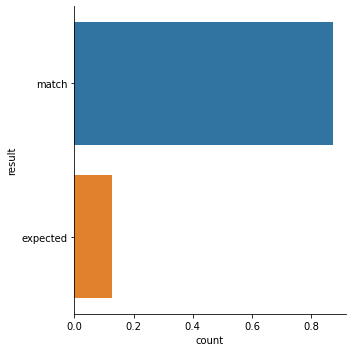

In [8]:
%%time

# Overwrite previous 'counts' dataframe with new results
counts = matches.groupby(['entry', 'refKey'])['rec_ent'] \
     .apply(list).reset_index(name = 'rec_ents')

counts = pd.merge(encoded_ents, counts, on = ['entry', 'refKey']) \
    .rename(columns = {'people':'enc_ents'})

# Each row is dedicate to one encoded entity per entry.
counts['enc_counts'] = 1
counts['rec_counts'] = counts['rec_ents'].str.len()

# Print totals.
print (counts[['enc_counts', 'rec_counts']].sum(), '\n')

# Define function to distinguish between expected behaviors by creating a new column.
def match_results(row):
    if row['enc_counts'] < row['rec_counts']:
        val = 'expected'
    elif row['enc_counts'] == row['rec_counts']:
        val = 'match'
    else:
        val = 'unexpected'
    return val

counts['results'] = counts.apply(match_results, axis = 1)

# Return a ratio of results.
counts = counts['results'].value_counts(normalize= True) \
    .reset_index() \
    .rename(columns = {'index':'result', 'results':'count'})

# Plot results.
g = sns.catplot(
    data = counts, kind = 'bar',
    y = 'result', x = 'count'
)

When focusing on only the matched entities, the NER results seem to be very good. An unexpected result would indicate that there are more encoded entities than recognized entities within a match, which should be impossible within the matched subset.

This indicates tentatively that there are very few false positives (if any). Even if NER is missing many entities (false negatives), at least there is a strong likelihood that the entities it does find are actual entities.

The good precision (few false positives) of NER suggests it could be useful for finding connections between entities, acknowledging that these connections are not complete. The connections that are here, however, can be useful for making argumentative claims.

## 3. Explore Unmatched Entities

This section seeks to explain why the NER process missed so many entities marked up by encoders. 

The unmatched entities are trickier to understand and disentangle. Entities might go unmatched for a few reasons:
1. The encoders supplied the reference. 
>Encoders might know who is referenced in phrases like "the cobbler's children," whereas NER would not.
2. NER misses entities.
>NER might pass over person names that should clearly be considered an entity. This could be the result of historical (and personalized) writing habits. Adams might not use a grammar that NER understands, especially in his diaries.
3. NER makes mistakes.
>NER might mislabel a person as an organization. This seems to be a common mistake in other projects, too (Six Degrees of Francis Bacon), at least enough to look into.

### a. Gather Unmatched Entities

There is a key step in the cell below that removes entities that do not have any matches. An encoded entity that does not match a single recognized entity is considered unmatched and separated from the matched results.

In [9]:
%%time
    
# Sequester encoded entities that do not match any recognized entities within entry.
'''
Rule for Unmatched Entities: 

An encoded entity has no (zero) NER match within an entry.
Unmatched entities are encoded entities completely overlooked by NER.
'''

# Gather the 'match status' for each encoded entity into a single list.
unmatched = entities.groupby(['file', 'entry', 'refKey', 'enc_ents']) \
    .apply(lambda x: [i for i in x['match_quality']]) \
    .reset_index(name = 'matches')

# Decalre values that indicate if an encoded entity has a single match.
match_list = ["Potential_Match", "Likely_Match"]

# Subset dataframe by selecting only entities that have zero matches.
unmatched = unmatched.groupby(['file', 'entry', 'refKey', 'enc_ents']) \
    .filter(lambda x: \
            any(i in match_list for i in list(chain.from_iterable(x['matches'].values))) \
            == False)

# Double-check to make sure all observations failed to match.
print ('All unique values in "matches column":',
       unmatched.explode('matches')['matches'].unique(), '\n')

print (unmatched.shape)
unmatched

All unique values in "matches column": ['Unlikely_Match'] 

(16790, 5)
CPU times: user 4.54 s, sys: 31.7 ms, total: 4.57 s
Wall time: 4.63 s


,file,entry,refKey,enc_ents,matches
1,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-07,connell-john,Connell,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."
2,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-07,wyer-edward,Wyer,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."
3,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-08,tucker-thomas,D,"[Unlikely_Match, Unlikely_Match, Unlikely_Match]"
4,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-09,connell-john,Connell,"[Unlikely_Match, Unlikely_Match]"
5,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-09,kean-s,S. Kean,"[Unlikely_Match, Unlikely_Match]"
...,...,...,...,...,...
24958,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."
24960,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,southard-samuel,M,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."
24962,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,thornton-william,D,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."
24963,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,wirt-william,M,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc..."


### b. Examine an Unmatched Entity

Now that the unmatched entities are collected, they should tell more about how, when, and why NER differs from the historical documents and encoding practices.

We'll start with a single entry and try to understand why an encoded name was overlooked.

In [10]:
entities.query('(entry == "jqadiaries-v49-1825-08-31") & (refKey == "rodgers-john")')

,file,entry,refKey,enc_ents,rec_ent,confidence,match_quality
1183,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,Andrews,33.0,Unlikely_Match
1183,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,John Sergeant,33.0,Unlikely_Match
1183,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,Marks,27.0,Unlikely_Match
1183,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,Foster,26.0,Unlikely_Match
1183,"('JQADiaries-v49-1825-08-p891.xml',)",jqadiaries-v49-1825-08-31,rodgers-john,Commodore Rodgers,Browne,26.0,Unlikely_Match


Read the context of unrecognized entities.

The entry for 'jqadiaries-v49-1825-08-31':

 31. V:15. Sun rose V:31. symbols 90 symbols  Foster came upon the business of Bennett, the ex-Consul at Pernambuco. I read Bennett’s papers while he was here— Except two in Portuguese, which are to be translated— I told Foster I should finally decide after comparing Bennett’s papers with those of Kirkpatrick— But said I saw not how Bennett could justify his requiring of Kirkpatrick proof that he was a Citizen U.S. before he would interpose to obtain his release from prison— N. Andrews is a chaplain in the U.S. Navy— Was a dissenting clergyman in England and came to this Country 30 years ago—with Dr. Priestley— Was with Captain Stewart in the Franklin, both in the Mediterranean and the Pacific— Now here as witness on Stewart’s trial— Called here—were on a visit—going to Baltimore— Dr Thornton called for his papers relating to his controversy with Mr Browne Secretary to the Franklin Society at Philadelphia— As to the right of every citizen to 

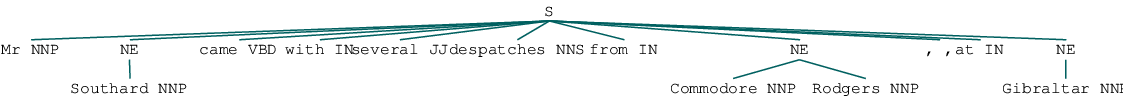

In [11]:
%%time

print ("The entry for 'jqadiaries-v49-1825-08-31':\n\n",
       ''.join(df.query('entry == "jqadiaries-v49-1825-08-31"')['text'].values))

text = "Mr Southard came with several despatches from Commodore Rodgers, at Gibraltar"

ne_chunk(pos_tag(word_tokenize(text)), '\n')

### c. Re-run NER on Encoded Entities <i>NOT</i> Found in First Pass

Does re-running NER on list of unmatched entities find more results? Does listing encoded entities help expand NER capacities?

In [12]:
%%time

# Get overview of how many unmatched entities are in dataset.
unmatched_ents = unmatched['enc_ents'].values.tolist()

unmatched_ents.sort()

print ('There are', len(set(unmatched_ents)),
       'unique unmatched entities.\n')

# Re-run NER on unmatched entities outside of their context.
unmatched['ner_names'] = unmatched \
    .apply(lambda row: get_continuous_chunks(row['enc_ents'],
                                             ['PERSON', 'ORGANIZATION']), axis = 1)

# Unnest list of tuples.
unmatched = unmatched.explode('ner_names')

# Remove null values in order to split tuples; will be re-join afterward.
unmatched_NotNull = unmatched.dropna()

# Split 'ner_names' column of tuple into two columns.
unmatched_NotNull[['ner_names', 'ner_labels']] = pd.DataFrame(unmatched_NotNull['ner_names'] \
                                                              .tolist(),
                                                      index = unmatched_NotNull.index)

# Re-join all unmatched data with null rows.
unmatched = pd.concat([unmatched, unmatched_NotNull], axis = 0)

# Delete unmatched_NotNull
del unmatched_NotNull

# Fill null values with informative value.
unmatched['ner_labels'] = unmatched['ner_labels'].fillna('UNRECOGNIZED')

unmatched.head()

There are 3813 unique unmatched entities.

CPU times: user 9.53 s, sys: 379 ms, total: 9.91 s
Wall time: 9.92 s


,file,entry,refKey,enc_ents,matches,ner_names,ner_labels
1,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-07,connell-john,Connell,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc...",NaN,UNRECOGNIZED
2,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-07,wyer-edward,Wyer,"[Unlikely_Match, Unlikely_Match, Unlikely_Matc...",NaN,UNRECOGNIZED
3,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-08,tucker-thomas,D,"[Unlikely_Match, Unlikely_Match, Unlikely_Match]",NaN,UNRECOGNIZED
4,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-09,connell-john,Connell,"[Unlikely_Match, Unlikely_Match]",NaN,UNRECOGNIZED
5,"('JQADiaries-v23-1821-05-p359.xml',)",jqadiaries-v23-1821-05-09,kean-s,S. Kean,"[Unlikely_Match, Unlikely_Match]",NaN,UNRECOGNIZED


### d. View Newly Matched Entities with re-run NER Results

         result     count
0  UNRECOGNIZED  0.837722
1        PERSON  0.129282
2  ORGANIZATION  0.032997 

CPU times: user 65.3 ms, sys: 4.9 ms, total: 70.2 ms
Wall time: 69.4 ms


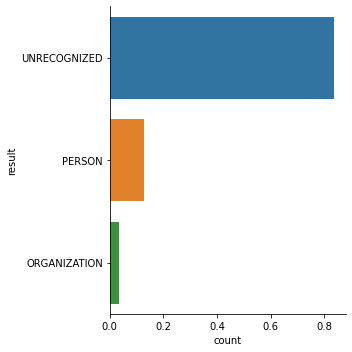

In [13]:
%%time

# Return a ratio of results.
counts = unmatched['ner_labels'].value_counts(normalize= True) \
    .reset_index() \
    .rename(columns = {'index':'result', 'ner_labels':'count'})

print (counts, '\n')

# Plot results.
g = sns.catplot(
    data = counts, kind = 'bar',
    y = 'result', x = 'count'
)

Even after re-running NER on a list of entities (text content), most entities (\~83%) remain unknown. Still, it might be worthwhile to add these newly found entities (~13%) to the NER model, which should increase the number of matches.

### e. Examine Known/Unknown Status of Entities

The last thing to understand in this notebook is why these unmatched entities are unrecognized. Glancing at the unmatched dataframe, names like 'Connell' and 'S. Kean' should be identified. Is the grammar of JQA's diaries such that NER has a difficult time guessing the part's of speech and, subsequently, the entities?

                   result     count
0    known + unrecognized  0.826530
1  unknown + unrecognized  0.083955
2      known + recognized  0.082685
3    unknown + recognized  0.006388
4                   Error  0.000443 

CPU times: user 4.61 s, sys: 42.8 ms, total: 4.65 s
Wall time: 4.66 s


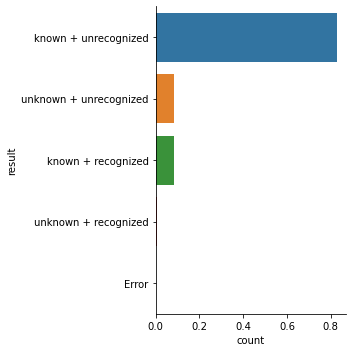

In [14]:
%%time

# Unnest refKeys.
unknown_ents = entities.explode('refKey')

# Create list of possible refKeys that signal uknown entity.
unknown_markers = ['.*unknown.*', 'None', 'u']

# Create a column and True/False depending on known/unknown status.
unknown_ents['known_status'] = unknown_ents['refKey'] \
    .str.contains(r'\b(?:{})\b'.format('|'.join(unknown_markers),
                  regex = True))

# Make True/False value more explicit as Un/Known.
unknown_ents['known_status'] = np.where(unknown_ents['known_status'] == True,
                                        'Unknown', 'Known')


# Declare status as Known + Recognized, Known + Unrec., Unknown + Rec., Unknown + Unrec.
def assign_knownRecogonized_status(row):
    if (row['known_status']) == "Known" and (row['confidence'] >= 65):
        val = 'known + recognized'
    elif (row['known_status']) == "Known" and (row['confidence'] < 65):
        val = 'known + unrecognized'
    elif (row['known_status']) == "Unknown" and (row['confidence'] >= 65):
        val = 'unknown + recognized'
    elif (row['known_status']) == "Unknown" and (row['confidence'] < 65):
        val = 'unknown + unrecognized'
    else:
        val = 'Error'
    return val

unknown_ents['status'] = unknown_ents.apply(lambda row: assign_knownRecogonized_status(row),
                                            axis = 1)

# Return a ratio of results.
counts = unknown_ents['status'].value_counts(normalize= True) \
    .reset_index() \
    .rename(columns = {'index':'result', 'status':'count'})

print (counts, '\n')

# Plot results.
ax = sns.catplot(
    data = counts, kind = 'bar',
    x = 'count', y = 'result'
)

## Findings

Using named entity recognition of the JQA diaries had mixed results. When NER finds an entity, there is a high likelihood that the result is accurate and not a false positive. This accuracy (precision) lends some (maybe minimal) optimism for using NER on other types of entities, organizations and places. Assuming it works as well on different entities, it should be possible to discover reliable place names, for example.

But, NER's success is limited. NER failed to find most of the people that the encoders identified. While this could be partly due to encoding practices (e.g. supplying contextual information for phrases like, 'so-and-so's children'), there are many more that NER should have recognized. I suspect that JQA's personalized and informal note taking eludes the rule-based probabilities that NER expects to find. As such, NER might be a poor tool for discovering other entities, again assuming that NER behaves consistently, which would surprise me.